# Training Model: Cnn + wavelets transform

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!pip install obspy

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from obspy import read
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [12]:
base_path = '/content/gdrive/MyDrive'

train_augmented_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/augmented'
train_ranges_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/augmented_ranges'
train_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/train'
val_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/val'
test_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/testing'
features_path = f'{base_path}/Notebooks/SeismicWaves/procesing'

In [5]:

def pad_or_trim(signal, target_length=8000):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    return signal

# ------------------- Funciones de Carga -------------------
def load_data(data_path):
    # Cargar señales crudas
    raw_signals = []
    files_df = pd.read_csv(os.path.join(data_path, 'feature_files.csv'))
    print(f'Cargando señales desde {data_path}...')
    for file in tqdm(files_df['file']):
        file_path = os.path.join(data_path, file)
        st = read(file_path)
        signal = st[0].data
        signal = pad_or_trim(signal, target_length=8000)
        raw_signals.append(signal)

    X_raw = np.array(raw_signals)
    X_raw = X_raw.reshape(X_raw.shape[0], -1, 1)  # Añadir dimensión para CNN

    # Cargar características wavelets
    X_wavelets = np.load(os.path.join(data_path, 'wavelet_features.npy'))

    # Cargar tiempos de llegada
    y = np.load(os.path.join(data_path, 'arrival_times.npy'))

    return X_raw, X_wavelets, y, files_df

In [8]:
# ------------------- Creación del Modelo -------------------
def create_model(input_shape_raw, input_shape_wavelets):
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    combined = tf.keras.layers.concatenate([x1, x2])

    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

### Ranges augmented data, v1 model

In [14]:
# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_ranges_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/augmented_ranges...


100%|██████████| 5940/5940 [1:15:08<00:00,  1.32it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [03:40<00:00,  1.44it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [05:56<00:00,  1.39it/s]


Formas:
Entrenamiento señales crudas: (5940, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


In [15]:

input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8000, 1)   │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4000, 64)  │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2000, 128) │     41,088 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]   

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

In [16]:

# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='augmented_ranges_huber_data.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 29.3437 - mae: 29.8424 - mse: 1090.6622 - val_loss: 28.0413 - val_mae: 28.5401 - val_mse: 827.3677 - learning_rate: 0.0010
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - loss: 26.8386 - mae: 27.3353 - mse: 939.2739 - val_loss: 20.3293 - val_mae: 20.8293 - val_mse: 443.9738 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 20.9118 - mae: 21.4076 - mse: 627.4357 - val_loss: 11.3529 - val_mae: 11.8516 - val_mse: 159.6410 - learning_rate: 0.0010
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 13.9951 - mae: 14.4889 - mse: 321.3628 - val_loss: 2.4371 - val_mae: 2.8844 - val_mse: 21.0958 - learning_rate: 0.0010
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 10.9127 - mae: 11.3997 - mse: 220.1279 - val_loss: 1.8010 - val_mae: 2.2411 - val_mse: 15.4871 - learning_rate: 0.0010
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 10.4443 - mae: 10.9255 - mse: 2

In [17]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'augmented_ranges_huber_data.csv'), index=False)

Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [18]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 0.6786 segundos
RMSE: 2.8132 segundos
Máximo error: 30.4912 segundos


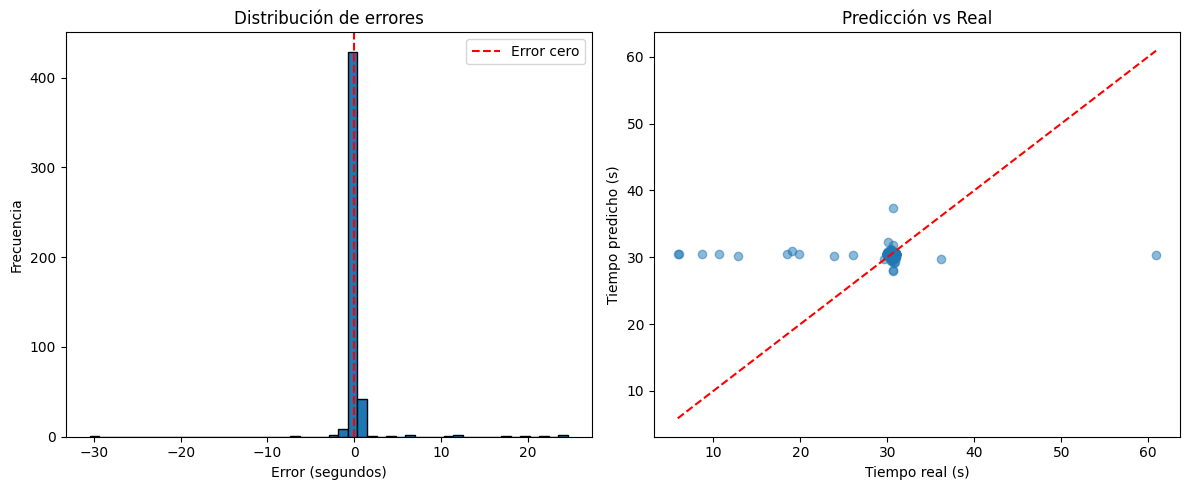


Estadísticas de errores:
Error medio: 0.1754 segundos
Desviación estándar: 2.8077 segundos
Mediana del error: -0.0529 segundos
Error dentro de ±0.5s: 85.3%
Error dentro de ±1.0s: 95.8%


In [19]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

In [24]:
def precision_con_tolerancia(y_true, y_pred, tolerancia_ms, sample_rate=1):
    # Convertimos la tolerancia de milisegundos a muestras
    tolerancia_muestras = int((tolerancia_ms / 1000) * sample_rate)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # True Positives: predicciones dentro de la ventana de tolerancia
    tp = np.sum(np.abs(y_true - y_pred) <= tolerancia_muestras)

    # False Positives: predicciones fuera de la ventana (pero que predijeron algo)
    fp = np.sum(np.abs(y_true - y_pred) > tolerancia_muestras)

    precision = tp / (tp + fp + 1e-10)  # para evitar división por cero
    return precision

# Asume que y_test e y_pred están en segundos
# Define tolerancias de ejemplo
tolerancias_ms = [20, 50, 100, 200, 500, 1000]  # puedes ajustar según tu aplicación

for tol in tolerancias_ms:
    prec = precision_con_tolerancia(
        y_true=y_test * 1000,       # convertir a ms
        y_pred=y_pred.flatten() * 1000,  # convertir a ms
        tolerancia_ms=tol,
        sample_rate=1000  # 1000 muestras por segundo
    )
    print(f"Precisión con tolerancia ±{tol}ms: {prec*100:.2f}%")



Precisión con tolerancia ±20ms: 5.24%
Precisión con tolerancia ±50ms: 12.10%
Precisión con tolerancia ±100ms: 19.76%
Precisión con tolerancia ±200ms: 39.52%
Precisión con tolerancia ±500ms: 85.28%
